In [1]:
import matplotlib.pyplot as plt
import numpy as np
from nuance.utils import periodic_transit, tv_dv
import numpy as np
import tinygp
import jax

jax.config.update("jax_enable_x64", True)


/Users/lgrcia/code/dev/nuance/nuance/nuance.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Dataset

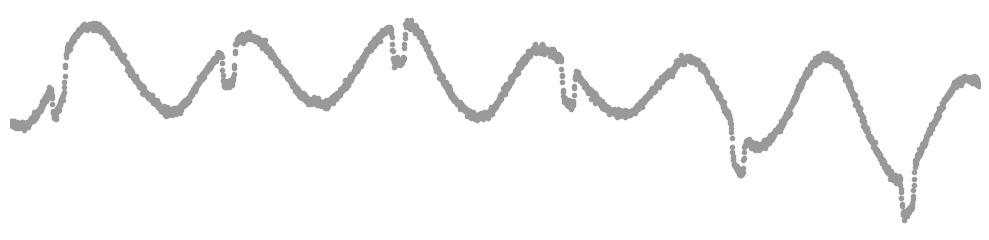

In [65]:
dt = 2 / 60 / 24
time = np.arange(0, 4, dt)
error = np.ones_like(time) * 0.001
X = np.vander(time, N=4, increasing=True)
w = [1.0, 5e-4, -2e-4, -5e-4]
true_period = 0.7
duration, depth = 0.05, 0.02
t0 = 0.2
true_transit = depth * periodic_transit(time, t0, duration, P=true_period)
mean = true_transit + X @ w

kernel = tinygp.kernels.quasisep.SHO(np.pi / (6 * duration), 45.0, depth)
gp = tinygp.GaussianProcess(kernel, time, diag=error**2, mean_value=mean)
diff_flux = gp.sample(jax.random.PRNGKey(40))
vari = diff_flux - mean

plt.figure(None, (10, 2.5))
plt.plot(time, diff_flux, ".", c="0.6")
plt.xlabel("time (days)")
plt.ylabel("diff. flux")
plt.xlim(time.min(), time.max())
# plt.title("example dataset", loc="left")
plt.axis("off")
plt.tight_layout()

plt.savefig("../figures/principle_dataset.pdf")


(0.0, 0.0, 0.0)
(0.5, 0.5, 0.5)
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)


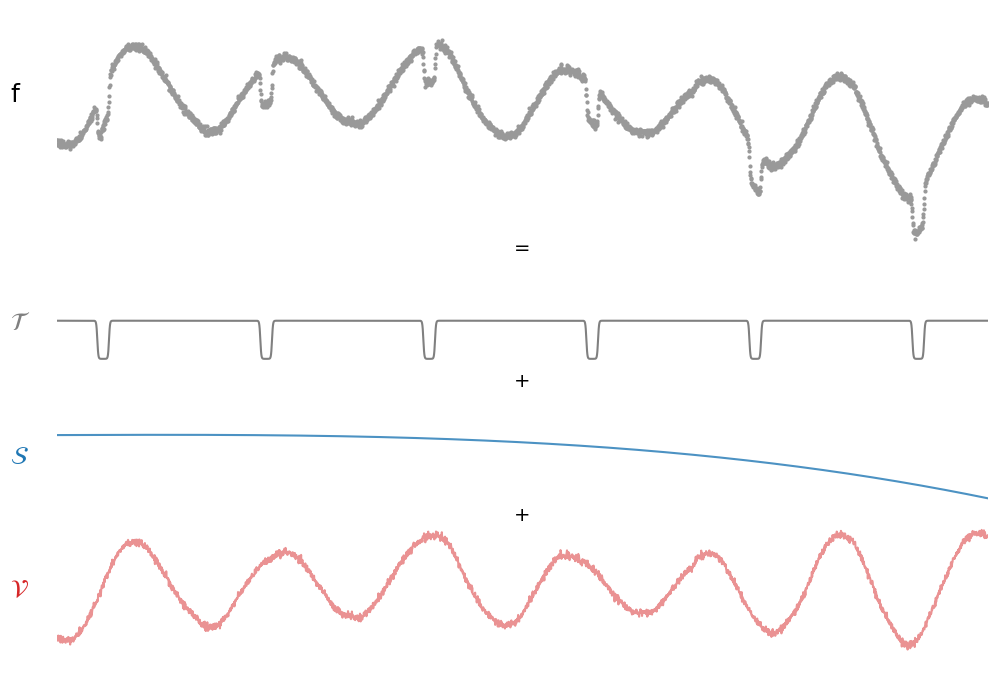

In [66]:
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(10.0, 7.0))
ax = plt.subplot(1, 1, 1)
h = 0.07
ax.plot(time, diff_flux + 0.05, ".", c="0.6", ms=4)
ax.plot(time, true_transit + 1.0 - h, c="0.5")
ax.plot(time, X @ w - 2 * h + 0.01, c="C0", alpha=0.8)
ax.plot(time, vari + 1.0 - 3 * h, c="C3", alpha=0.5)
ax.axis("off")
ax.set_xlim(time.min(), time.max())
ax.axis("off")
ax.set_ylabel("diff. flux")
ax.set_xlabel("time (days)")
ax.text(time.mean(), 1.0 - (0 + 0.5) * h, "=", ha="center", fontsize=14)
[
    ax.text(time.mean(), 1.0 - (i + 0.5) * h, "+", ha="center", fontsize=14)
    for i in [1, 2]
]
for text, color, y in zip(
    ["f", "$\mathcal{T}$", "$\mathcal{S}$", "$\mathcal{V}$"],
    ["k", "0.5", "C0", "C3"],
    [1 + 0.05, 1.0 - h, 1.0 - 2 * h, 1.0 - 3 * h],
):
    ax.text(-0.2, y - 0.005, text, ha="left", fontsize=18, color=color)
    print(mcolors.to_rgb(color))

plt.tight_layout()
plt.savefig("../figures/principle_dataset_decomposed.pdf")


# Linear Search

In [68]:
from nuance import Nuance

gp = tinygp.GaussianProcess(kernel, time, diag=error**2, mean=0.0)
nu = Nuance(time, diff_flux, gp=gp, X=X.T)

t0s = time.copy()
Ds = np.linspace(0.0001, 0.1, 30)
nu.linear_search(t0s, Ds)


100%|██████████| 2880/2880 [00:02<00:00, 1004.76it/s]


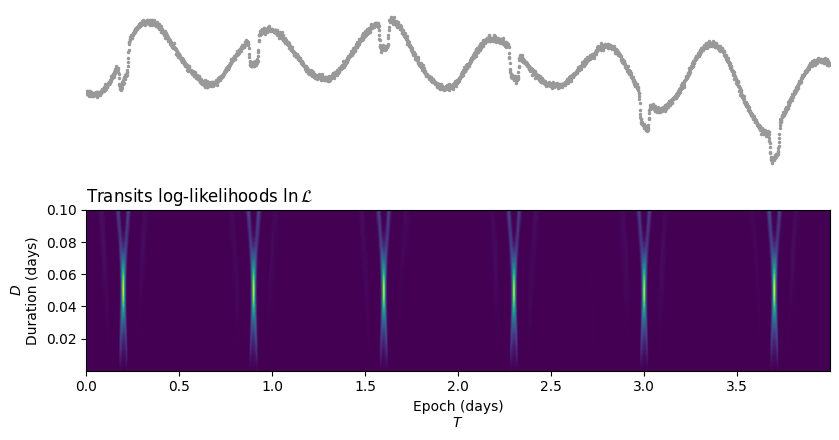

In [70]:
plt.figure(None, (8.5, 4.5))
plt.subplot(211)
plt.plot(time, diff_flux, ".", c="0.6", ms=3)
plt.ylabel("diff. flux")
plt.xlim(time.min(), time.max())
plt.axis("off")

plt.subplot(212)
extent = np.min(t0s), np.max(t0s), np.min(Ds), np.max(Ds)
plt.imshow(nu.search_data.ll.T, aspect="auto", origin="lower", extent=extent)

plt.ylabel("$D$\nDuration (days)")
plt.xlabel("Epoch (days)\n$T$")
plt.title("Transits log-likelihoods $\mathcal{\ln L}$", loc="left")
plt.tight_layout()

plt.savefig("../figures/principle_linear_search.pdf")

# Periodic search

In [71]:
periods = np.linspace(0.1, 3, 5000)
search = nu.periodic_search(periods)

100%|██████████| 5000/5000 [00:07<00:00, 687.49it/s] 


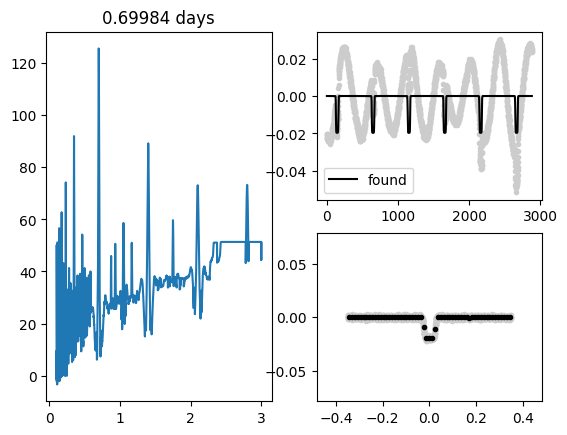

In [72]:
from nuance.utils import plot_search

plot_search(nu, search)

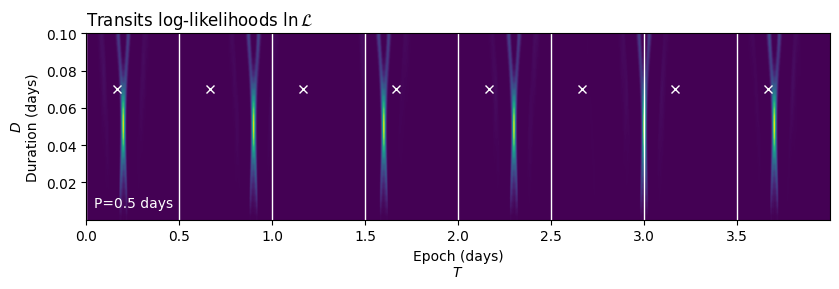

In [74]:
W = 8.5
H = 3.0
plt.figure(None, (W, H))

periods = [0.35, 0.5, 0.7, 0.9]
P1 = periods[1]
fold = nu.search_data.fold_ll
pt0s, Pv, Pc = fold(P1)
extent = nu.time.min(), nu.time.max(), nu.search_data.Ds.min(), nu.search_data.Ds.max()
k = len(pt0s) // 3

plt.imshow(search.ll.T, aspect="auto", origin="lower", extent=extent)
plt.xlim(nu.time.min(), nu.time.max())
plt.ylabel("$D$\nDuration (days)")
plt.xlabel("Epoch (days)\n$T$")
plt.title("Transits log-likelihoods $\ln\mathcal{L}$", loc="left")

for i in range(int(np.ceil((nu.time.max() - nu.time.min()) / P1))):
    plt.axvline(i * P1, c="w", lw=1)
    plt.plot((i + pt0s[k]) * P1, 0.07, "x", c="w")

plt.text(
    0.01,
    0.05,
    f"P={P1} days",
    fontsize=10,
    c="w",
    ha="left",
    va="bottom",
    transform=plt.gca().transAxes,
)

plt.tight_layout()
plt.savefig("../figures/principle_periodic_0.pdf")


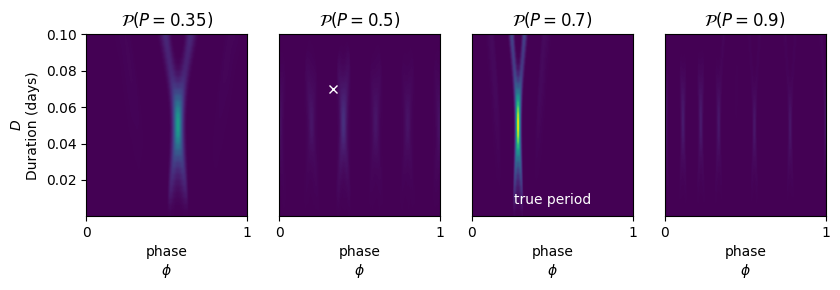

In [79]:
plt.figure(None, (W, H))

n = len(periods)

Pc = fold(true_period)[2]
Pc -= np.median(Pc)
M = np.max(Pc)
extent = 0, 1, nu.search_data.Ds.min(), nu.search_data.Ds.max()


for i, P in enumerate(periods):
    fold = nu.search_data.fold_ll
    pt0s, Pv, Pc = fold(P)

    ax = plt.subplot(1, n, i + 1)
    if i == 0:
        plt.ylabel("$D$\nDuration (days)")

    Pc -= np.median(Pc)
    plt.imshow(
        Pc.T, aspect="auto", extent=extent, origin="lower", vmin=np.median(Pc), vmax=M
    )
    plt.xlabel("phase\n$\phi$")
    plt.title(rf"$\mathcal{{P}}(P={{{P}}})$")

    if P == true_period:
        plt.text(
            0.5,
            0.05,
            f"true period",
            fontsize=10,
            c="w",
            ha="center",
            va="bottom",
            transform=plt.gca().transAxes,
        )

    if P == P1:
        plt.plot(pt0s[k], 0.07, "x", c="w")

    plt.tick_params(axis="y", which="both", left=i == 0, labelleft=i == 0)
    ax.set_xticks([0, 1], ["0", "1"])

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig("../figures/principle_periodic_1.pdf")


# Periodogram

In [80]:
P = true_period
phases, _, Pc = fold(P)

i, j = np.unravel_index(np.argmax(Pc), Pc.shape)
_phi, _D = phases[i], nu.search_data.Ds[j]
_t0 = _phi * P


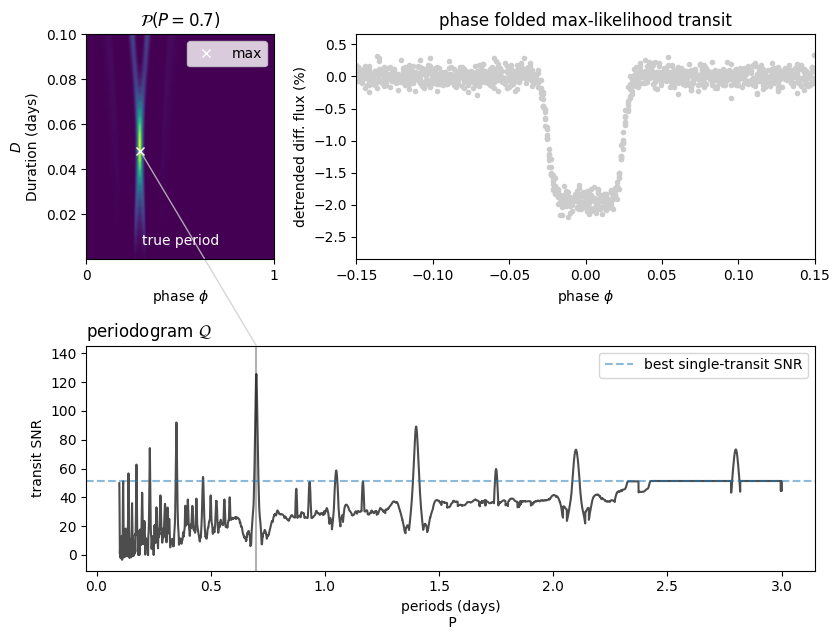

In [84]:
from nuance.utils import phase, binn
from matplotlib.patches import ConnectionPatch

plt.figure(None, (8.5, 6.5))

ax0 = plt.subplot(2, 3, 1)
plt.imshow(Pc.T, aspect="auto", extent=extent, origin="lower")
plt.xlabel("phase $\phi$")
plt.ylabel("$D$\nDuration (days)")
plt.plot(_phi, _D, "x", c="w", label="max")
plt.title(f"$\mathcal{{P}}(P={{{P}}})$")
ax0.set_xticks([0, 1], ["0", "1"])
ax0.text(
    0.5,
    0.05,
    f"true period",
    fontsize=10,
    c="w",
    ha="center",
    va="bottom",
    transform=ax0.transAxes,
)
plt.legend()

ax = plt.subplot(2, 3, (2, 3))
mean, astro, noise = nu.models(_t0, _D, P)
phi = phase(nu.time, _t0, P)
detrended = (nu.flux - noise - mean) * 100  # percent
plt.plot(phi, detrended, ".", c=".8")
plt.xlim(*(np.array([-1, 1]) * 3 * duration))
_depth = float(np.abs(detrended.min()))
plt.ylim(*(np.array([-1, 1]) * _depth * 0.8 - _depth / 2))
plt.xlabel("phase $\phi$")
ax.set_title(f"phase folded max-likelihood transit")
plt.ylabel("detrended diff. flux (%)")

ax_per = plt.subplot(2, 3, (4, 6))
ax_per.plot(search.periods, search.Q_snr, c="0.3")
ax_per.set_title("periodogram $\mathcal{Q}$", loc="left")
ax_per.set_xlabel("periods (days)\n P")
ax_per.set_ylabel("transit SNR")
ax_per.axvline(true_period, c="k", alpha=0.3)
ylim = np.array(ax_per.get_ylim())
ax_per.set_ylim(*(ylim * 1.1))
con = ConnectionPatch(
    xyA=(_phi, _D),
    xyB=(P, ax_per.get_ylim()[1]),
    coordsA="data",
    coordsB="data",
    axesA=ax0,
    axesB=ax_per,
    color="0.8",
    alpha=0.8,
)
ax0.add_artist(con)
snr_0 = float(nu.snr(_t0, _D, 1000))
plt.axhline(snr_0, alpha=0.5, ls="--", label="best single-transit SNR")
plt.legend()
# ax_per.text(2.5, 40, f"best non-periodic\ntransit SNR", fontsize=10, c="C0", alpha=0.8, ha='center', va='top')


plt.tight_layout()
plt.savefig("../figures/principle_Q.pdf")


In [279]:
snr_0 = float(nu.snr(_t0, _D, 1000))

51.18065156693503

In [223]:
detrended.min()

DeviceArray(-0.02193351, dtype=float64)

In [ ]:
c = "k"
alpha = 0.15
for i in range(int(np.ceil((nu.time.max() - nu.time.min()) / P))):
    ax0.axvline(i * P, c="w", lw=1)
    con = ConnectionPatch(
        xyA=(1.0, 1.0),
        xyB=(i * P, 0.0),
        coordsA="axes fraction",
        coordsB="data",
        axesA=ax2,
        axesB=ax0,
        color=c,
        zorder=-1,
        alpha=alpha,
    )
    ax.add_artist(con)
    con = ConnectionPatch(
        xyA=(0.0, 1.0),
        xyB=(i * P, 0.0),
        coordsA="axes fraction",
        coordsB="data",
        axesA=ax2,
        axesB=ax0,
        color=c,
        zorder=-1,
        alpha=alpha,
    )
    ax.add_artist(con)

ax0.set_title(f"P={P} days likelihood folds", loc="left", zorder=10)
ax.set_zorder(2)
ax0.set_zorder(1)

ax_per = plt.subplot(3, 2, (7, 9))
ax_per.plot(*search.periodogram(), c="0.3")
ax_per.set_title("periodogram", loc="left")
ax_per.set_xlabel("periods (days)\n P")
ax_per.set_ylabel("transit SNR")
ax_per.axvline(true_period, c="k", alpha=0.3)
ylim = np.array(ax_per.get_ylim())
ax_per.set_ylim(*(ylim * 1.1))
con = ConnectionPatch(
    xyA=(t0, duration),
    xyB=(true_period, ax_per.get_ylim()[1]),
    coordsA="data",
    coordsB="data",
    axesA=ax2,
    axesB=ax_per,
    color="0.8",
    alpha=0.8,
)
ax.add_artist(con)

plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.35)
# plt.savefig("../figures/principle_Q.pdf")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# generate some data
x = np.arange(0, 10, 0.2)
y = np.sin(x)

# plot it
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={"width_ratios": [3, 1]})
a0.plot(x, y)
a1.plot(y, x)

f.tight_layout()
f.savefig("grid_figure.pdf")
